## Explanation 1: Why do we need tokenization?

Large Language Models (LLMs) like GPT **cannot work directly with text** because:

1. **Neural networks only process numbers**: They require numerical vectors as input, not characters or words.
2. **Text is discrete and symbolic**: There is no natural mathematical representation for language.

### Why is Byte Pair Encoding (BPE) superior?

Let's compare three approaches:

| Approach | Advantages | Disadvantages |
|---------|----------|-------------|
| **Characters** | Small vocabulary (~100) | Very long sequences, loses semantics |
| **Words** | Maintains semantic units | Huge vocabulary, problems with new words (OOV) |
| **BPE** | Perfect balance: medium vocabulary (~50k), handles rare words, manageable sequences | - |

### How does tiktoken implement BPE for GPT?

`tiktoken` is OpenAI's library that implements BPE:

1. **Learns frequent patterns**: Merges pairs of bytes that frequently appear together
2. **Subword tokenization**: Common words = 1 token, rare words = multiple tokens
3. **Example**: "tokenization" → `["token", "ization"]` or `["tok", "en", "ization"]`

This enables:
- Handling any word (even invented ones)
- Finite and manageable vocabulary
- Capturing morphology (prefixes, suffixes)

## Explanation 2: Why use sliding windows to create samples?

Sliding windows are a technique for dividing a long text into smaller parts (windows) that can be used to train a model.

How does it work?
Windows: Each window has a fixed number of words or tokens (called max_length).
Stride: To create the next window, we advance a certain number of words (stride).

Example:
Imagine you have this text:
[A, B, C, D, E, F, G, H]

If we use:

max_length = 4 (each window has 4 words)
stride = 2 (we advance 2 words for the next window)
We get:

Window 1: [A, B, C, D]
Window 2: [C, D, E, F] (2 words are repeated: overlap)
Window 3: [E, F, G, H]
Why is it useful?
More information: From a long text, we generate many windows for training.
Context: The words are displayed in different positions, helping the model understand them better.
Long texts: Transformers can only process a limited number of words (e.g., 2048). The sliding window divides long texts into smaller parts.

## Explanation 3: Why do embeddings encode meaning?

An embedding is a way to convert words or tokens into numbers (vectors) that computers can understand. Instead of using a unique number for each word, we use a vector (a list of numbers) that captures the word's meaning.

How Do Embeddings Learn?

- They start randomly: Initially, the vectors have no meaning.

- Training: During model training, the vectors are adjusted so that words with similar meanings have similar vectors.

- Context: If two words appear in similar contexts, their vectors become similar.

- Result: After extensive training, the vectors capture relationships between words.

Example of Semantic Relationships

Embeddings can capture relationships such as:

- "King" - "Man" + "Woman" ≈ "Queen"
- "Paris" - "France" + "Italy" ≈ "Rome"

This means that the vectors understand concepts like gender or location.

Why Do We Use High-Dimensional Vectors?

- In a large space (such as 256 or 768 dimensions), there is enough "space" to represent many relationships simultaneously.

- Each dimension can represent something different, such as gender, time, or formality.

- The similarity between words is measured by the cosine distance: words that are closer together have more similar meanings.

## Explanation 4: Why do we need positional encodings?

The Problem:

- Transformers Don't Understand Order
Unlike other models such as RNNs, transformers don't know the order in which words appear. For example:

- "The dog chases the cat"

- "The cat chases the dog"

- They have the same words, but they mean opposite things. Without order information, the model cannot differentiate these phrases.

The Solution:
- Positional Encodings
To enable the model to understand order, positional information is added to the words. This is done by adding a "position vector" to the "word vector":

Types of Positional Encodings
- Fixed (sinusoidal): Use mathematical formulas (sine and cosine) to represent positions.

- Example: Original Transformer.

- Learnable: The model learns which positions are important during training.

- Example: GPT, BERT.

- Relative: Represent the distance between words instead of exact positions.

- Example: T5, Transformers XL.

Why Are They Important?

- Order Matters: "It's not good" is not the same as "It's not good."

- Structure: They help us understand complex sentences like "John said that Mary thinks that...".

- Longer Context: They allow us to know how far apart two words are in a sentence.

---

# Experiment: Effect of max_length and stride on data sampling

In this section, we will conduct an experiment to understand how the parameters `max_length` and `stride` affect the number of samples generated and the overlap between windows.

In [ ]:
# !pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 5.6 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/8.1 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.1 MB 2.8 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.1 MB 2.0 MB/s eta 0:00:04
   -------------- ------------------------- 2.9/8.1 MB 2.6 MB/s eta 0:00:03
   ----------------------- ---------------- 4.7/8.1 MB 3.6 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 4.3 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 4.2 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 4.2 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 4.2 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 3.1 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 3.1 MB/s eta 0:00:01
   ----------------

In [1]:
import matplotlib.pyplot as plt
import numpy as np

text = "Este es un texto de ejemplo con muchas palabras para demostrar como funciona el sliding window con diferentes configuraciones"
tokens = text.split()

configs = [
    (4, 1),
    (4, 2),
    (4, 4),
    (6, 1),
    (6, 2),
    (6, 3),
    (8, 2),
    (8, 4),
]
results = []

print("EXPERIMENTO:")
for max_len, stride in configs:
    samples = []
    for i in range(0, len(tokens) - max_len + 1, stride):
        samples.append(tokens[i:i + max_len])
    overlap = max_len - stride
    num_samples = len(samples)

    results.append({'max_length': max_len,'stride': stride,'samples': num_samples,'overlap': overlap})
    print(f"max_length={max_len:2d}, stride={stride:2d} → {num_samples:3d} muestras | overlap={overlap} tokens")



EXPERIMENTO:
max_length= 4, stride= 1 →  16 muestras | overlap=3 tokens
max_length= 4, stride= 2 →   8 muestras | overlap=2 tokens
max_length= 4, stride= 4 →   4 muestras | overlap=0 tokens
max_length= 6, stride= 1 →  14 muestras | overlap=5 tokens
max_length= 6, stride= 2 →   7 muestras | overlap=4 tokens
max_length= 6, stride= 3 →   5 muestras | overlap=3 tokens
max_length= 8, stride= 2 →   6 muestras | overlap=6 tokens
max_length= 8, stride= 4 →   3 muestras | overlap=4 tokens


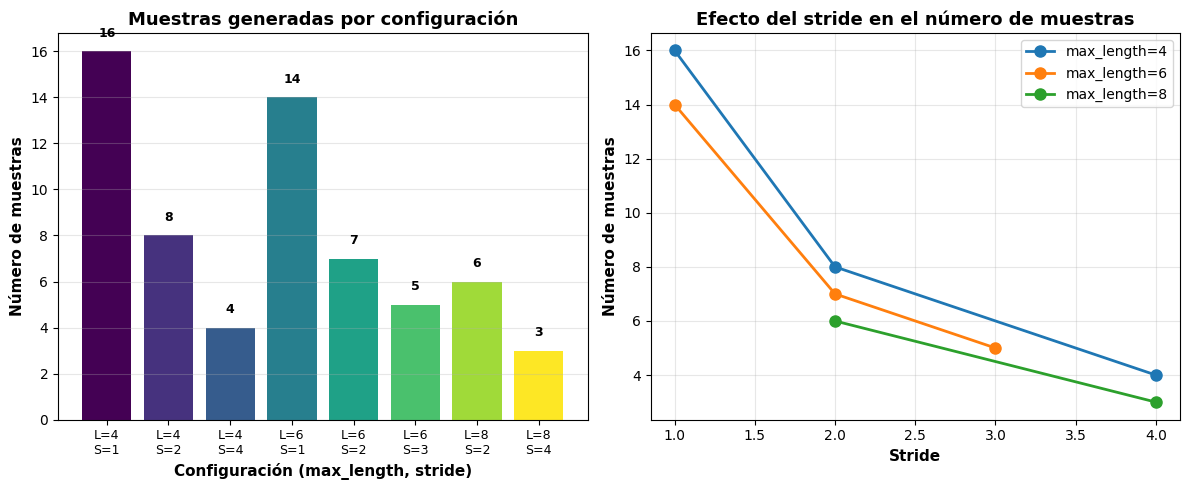

In [2]:
max_lengths = [r['max_length'] for r in results]
strides = [r['stride'] for r in results]
num_samples = [r['samples'] for r in results]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
x_labels = [f"L={r['max_length']}\nS={r['stride']}" for r in results]
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
bars1 = ax1.bar(range(len(results)), num_samples, color=colors)
ax1.set_xlabel('Configuración (max_length, stride)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Número de muestras', fontsize=11, fontweight='bold')
ax1.set_title('Muestras generadas por configuración', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(results)))
ax1.set_xticklabels(x_labels, fontsize=9)
ax1.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars1, num_samples)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(val), ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2 = axes[1]
for ml in sorted(set(max_lengths)):
    data = [(r['stride'], r['samples']) for r in results if r['max_length'] == ml]
    data.sort()
    s, n = zip(*data)
    ax2.plot(s, n, marker='o', linewidth=2, markersize=8, label=f'max_length={ml}')

ax2.set_xlabel('Stride', fontsize=11, fontweight='bold')
ax2.set_ylabel('Número de muestras', fontsize=11, fontweight='bold')
ax2.set_title('Efecto del stride en el número de muestras', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()